In [23]:
from os import listdir, path
from pyteomics import fasta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy import stats
import numpy as np
from glob import glob
import os
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
sns.set_style('whitegrid')

In [ ]:
fastafile = '/projects/mipt_dbmp_biotechnology/proteomics/sp_human_canonical_2023-09-06_shuffled.fasta'

Задача: сравни

# Конвертация сырых спектров в mzML (26 минут, предлагаю показать на одном файле)

In [ ]:
!for file in /projects/mipt_dbmp_biotechnology/proteomics/hw; do /projects/mipt_dbmp_biotechnology/soft/ThermoRawFileParser/ThermoRawFileParser -i $file -o $mzML; done

# Идентификация белков (на 32 Гб и 40 потоках 6 минут)

Запускаем MSFragger через slurm

# Пост-поисковая валидация (15 минут)

In [4]:
%%time
filedir = 'mzML'
outdir = 'mzML'
for file in listdir(filedir):
    filename = file.split('.')[0] 
    if file.endswith('.pepXML') and filename + '_protein_groups.tsv' not in listdir(outdir):
        print(file)
        path_to_pepxml = path.join(filedir, file)
        !scavager -p DECOY_ -db $fastafile -o $outdir $path_to_pepxml

LUM2_00721_VG_3821B_1.pepXML
     INFO: [06:16:09] 1 file(s) to process.
     INFO: [06:16:10] Loading file LUM2_00721_VG_3821B_1.pepXML...
     INFO: [06:16:21] Default target-decoy filtering, 1% PSM FDR: Number of target PSMs = 39344
     INFO: [06:16:21] Calibrating retention model...
     INFO: [06:16:42] RT model training results: R^2 = 0.848568 , std = 10.958476
     INFO: [06:16:42] Retention model calibrated successfully.
     INFO: [06:16:43] Starting machine learning...
TBB Warning: The number of workers is currently limited to 31. The request for 111 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

     INFO: [06:17:03] Machine learning is finished.
     INFO: [06:17:08] Final results at 1.0% FDR level:
     INFO: [06:17:08] Identified PSMs: 40328
     INFO: [06:17:08] Identified peptides: 28647
     INFO: [06:17:08] Identified proteins: 4864
     INFO: [06:17:08] Identified protein groups: 4260
     INFO: [06:17:08] Pr

# Количественный анализ + анализ дифференциальной экспресии

## Считаем число белков в фасте

In [5]:
i = 0
for p in fasta.read(fastafile):
    i+=1
print("Число настоящих белков в базе данных:",  i//2)

Число настоящих белков в базе данных: 20423


## Создаем sample-file

In [6]:
sample_df = pd.DataFrame(columns = ['File Name', 'SampleID'])
filedir = 'mzML'
for file in listdir(filedir):
    if file.endswith('protein_groups.tsv'):
        name = file.split('_protein_groups')[0]
        sample = file.split('VG_')[1].split('_')[0]
        tmp_dict = {'File Name': [file],
                    'SampleID':[sample]}
        sample_df = pd.concat([sample_df, pd.DataFrame.from_dict(tmp_dict)])
sample_df.to_csv('sample_file.csv')

In [7]:
sample_df

,File Name,SampleID
0,LUM2_00791_VG_6138K_2_protein_groups.tsv,6138K
0,LUM2_00820_VG_4114B_4_protein_groups.tsv,4114B
0,LUM2_00806_VG_6138A_1_protein_groups.tsv,6138A
0,LUM2_00854_VG_4114A_2_protein_groups.tsv,4114A
0,LUM2_00857_VG_4114A_5_protein_groups.tsv,4114A
0,LUM2_00809_VG_6138A_4_protein_groups.tsv,6138A
0,LUM2_00836_VG_4114K_2_protein_groups.tsv,4114K
0,LUM2_00801_VG_6138B_4_protein_groups.tsv,6138B
0,LUM2_00793_VG_6138K_4_protein_groups.tsv,6138K
0,LUM2_00853_VG_4114A_1_protein_groups.tsv,4114A


In [8]:
filedir = 'mzML'
sample_file = 'sample_file.csv'
outdir = 'qreps'

labels = '3821A,3821K 3821B,3821K'

!qreps --sample-file $sample_file --labels $labels\
    --input-dir $filedir --output-dir $outdir\
    --imputation kNN --thresholds semi-dynamic --alpha 0.01 --regulation UP\
    --fasta-size 20423 --species 9606 --report True

## Анализ дифференциальной экспрессии

In [5]:
files = glob("mzML/*_protein_groups.tsv")
data = []

for file in files:
    df = pd.read_csv(file, sep='\t')
    sample = os.path.basename(file).replace('_protein_groups.tsv', '')
    
    culture = sample.split('_VG_')[1][:4]
    condition = sample.split('_VG_')[1][4]
    
    df['culture'] = culture
    df['condition'] = condition
    df['sample'] = sample
    
    df = df[['dbname', 'NSAF', 'q', 'culture', 'condition', 'sample']]
    data.append(df)

df_all = pd.concat(data, ignore_index=True)


In [28]:
# Фильтрация
df_clean = df_all.dropna(subset=['NSAF'])
protein_counts = df_clean['dbname'].value_counts()
df_clean = df_clean[df_clean['dbname'].isin(protein_counts[protein_counts >= 3].index)]

results = []

In [29]:
# ANOVA
for protein, subdf in df_clean.groupby('dbname'):
    try:
        conds = subdf['condition'].unique()
        if not set(['A', 'B', 'K']).issubset(set(conds)):
            continue
        
        counts = subdf['condition'].value_counts()
        if any(counts < 2):
            continue  # пропускаем белки с малым числом наблюдений
        
        model = ols('NSAF ~ C(condition)', data=subdf).fit()
        
        if model.df_resid <= 0:
            continue

        anova_table = sm.stats.anova_lm(model, typ=2)
        pval = anova_table["PR(>F)"].iloc[0]
        
        results.append({'dbname': protein, 'anova_pval': pval})
    except Exception:
        continue

In [30]:
anova_df = pd.DataFrame(results)
anova_df['padj'] = sm.stats.multipletests(anova_df['anova_pval'], method='fdr_bh')[1]

In [32]:
sig_proteins = anova_df[anova_df['padj'] < 0.05]['dbname']

In [35]:
# Тест Тьюки

tukey_results = []
for protein in sig_proteins:
    subdf = df_clean[df_clean['dbname'] == protein]
    tukey = pairwise_tukeyhsd(subdf['NSAF'], subdf['condition'], alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_df['dbname'] = protein
    tukey_results.append(tukey_df)

tukey_all = pd.concat(tukey_results, ignore_index=True)

<Figure size 640x480 with 0 Axes>

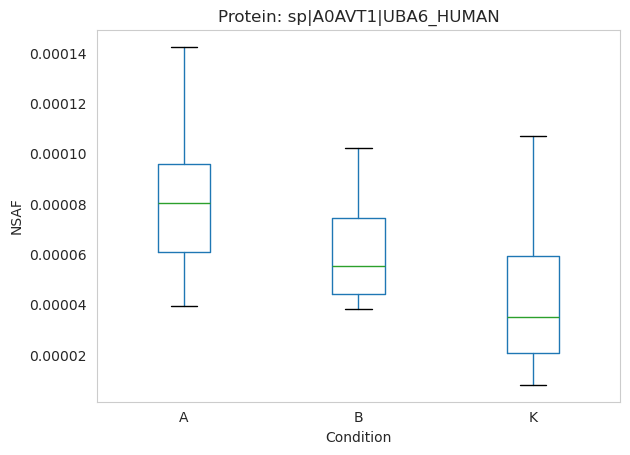

<Figure size 640x480 with 0 Axes>

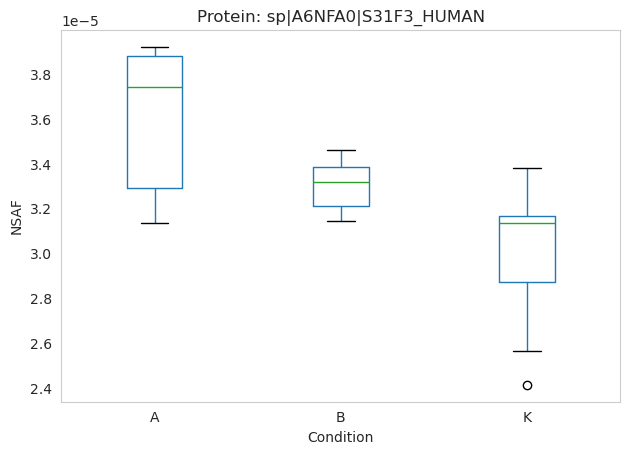

<Figure size 640x480 with 0 Axes>

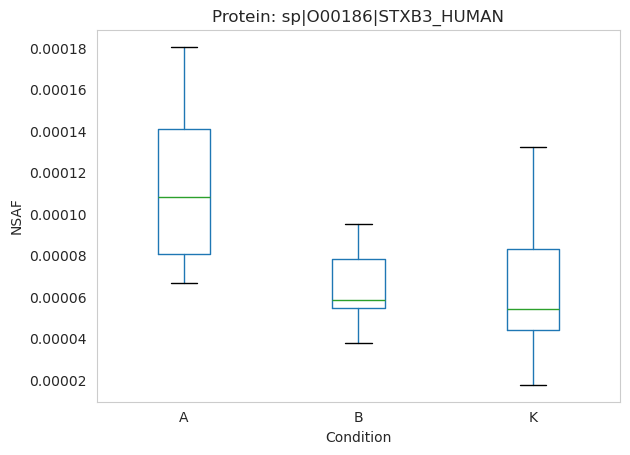

<Figure size 640x480 with 0 Axes>

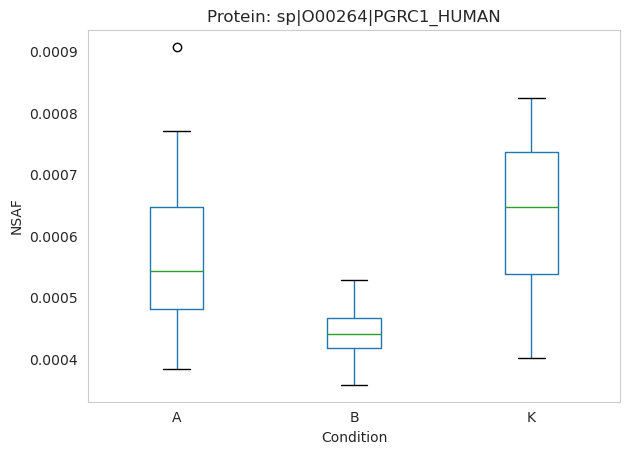

<Figure size 640x480 with 0 Axes>

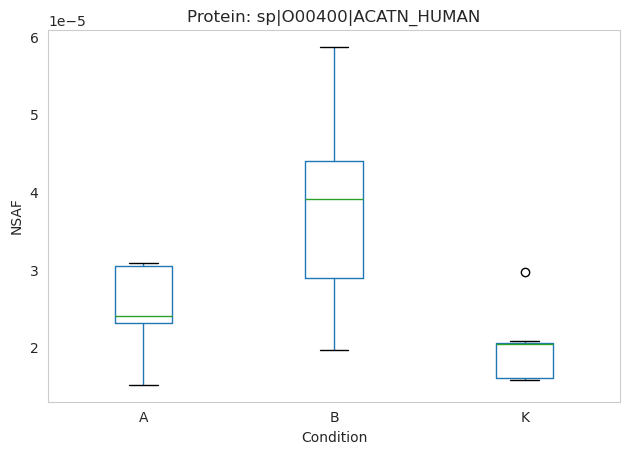

In [36]:
# Боксплоты для нескольких белков

for protein in sig_proteins[:5]:
    sub = df_clean[df_clean['dbname'] == protein]
    plt.figure()
    sub.boxplot(column='NSAF', by='condition', grid=False)
    plt.title(f'Protein: {protein}')
    plt.suptitle('')
    plt.xlabel('Condition')
    plt.ylabel('NSAF')
    plt.tight_layout()
    plt.show()

In [38]:
anova_df.to_csv('anova_results.csv', index=False)
tukey_all.to_csv('tukey_results.csv', index=False)
sig_proteins.to_csv('sig_anova_results.csv', index=False)

Выводы: был получен список дифференциально представленных белков в сравнении между двумя группами по приему интерферона и контрольной группой (sig_anova_results.csv). С применением теста Тьюки, для каждого белка была выявлена группа, для которой содержание белка повышено или понижено (tukey_results.csv).